In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
import numpy as np
import time
import matplotlib.pyplot as plt
import math

In [2]:
img=128
img_size=[img,img]

numOfClasses=26
batchSize=64
Epochs=30

In [3]:
model= tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(50,(2,2), input_shape=(img,img,3)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(70,(3,3)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(70,(3,3)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(numOfClasses, activation="softmax")

])

C:\Users\zapat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [4]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 127, 127, 50)   │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 127, 127, 50)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 70)     │        31,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 61, 61, 70)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 70)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 70)     │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 70)     │        44,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 28, 28, 70)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 70)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 70)     │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,512,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,596,408 (13.72 MB)

 Trainable params: 3,596,028 (13.72 MB)

 Non-trainable params: 380 (1.48 KB)

None


In [5]:
optimizer = Adam(learning_rate=0.001,
                beta_1=0.9,
                beta_2=0.999,
                decay=0.001)
loss_function = BinaryCrossentropy()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

C:\Users\zapat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [6]:
trainFolder=r"train"
testFolder=r"validation"

In [7]:
train_datagen=ImageDataGenerator(rescale=1. / 255)
training_set=train_datagen.flow_from_directory(trainFolder,
                                               shuffle=True,
                                               target_size=img_size,
                                               batch_size=batchSize,
                                               class_mode="categorical"
                                               )

Found 8605 images belonging to 26 classes.


In [8]:
test_datagen=ImageDataGenerator(rescale=1. / 255)
test_set=test_datagen.flow_from_directory(testFolder,
                                            shuffle=False,
                                            target_size=img_size,
                                            batch_size=batchSize,
                                            class_mode="categorical",
                                            #color_mode="grayscale"
                                            )

Found 1024 images belonging to 26 classes.


In [9]:
stepsPerEpochs = int(np.ceil(training_set.samples / batchSize))
validationSteps = int(np.ceil(test_set.samples / batchSize))


# OJO CON EL .KERAS O .H5

In [10]:
model_file="train_model/modelo1.keras"
bestModel=ModelCheckpoint(model_file, monitor="val_accuracy", save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=7)

In [11]:
def create_class_weight(generator, mu=0.8):
    labels_dict = generator.classes
    total = len(generator.classes)
    unique_labels = np.unique(generator.classes)
    class_weight = dict()

    for label in unique_labels:
        class_count = np.sum(generator.classes == label)
        score = math.log(mu * total / float(class_count))
        class_weight[label] = score if score > 1.0 else 1.0

    return class_weight

class_weights_u = create_class_weight(training_set)
print(class_weights_u)

{0: 4.182994807173906, 1: 4.231784971343338, 2: 1.0, 3: 1.5708263777749791, 4: 3.677899858116901, 5: 4.337145487001165, 6: 3.9694207068758476, 7: 3.672169183407916, 8: 3.8065172359389945, 9: 3.853348535623094, 10: 2.9818832351290028, 11: 2.8682475973460644, 12: 3.5952081422717876, 13: 3.761781342097603, 14: 4.1641263228695236, 15: 3.874110527071523, 16: 4.049463414549384, 17: 3.276273526315902, 18: 4.000673250379952, 19: 3.8811280997301694, 20: 4.678072073971758, 21: 4.118456286036335, 22: 4.083364966225066, 23: 2.928872219162499, 24: 4.442506002658991, 25: 2.257703945321329}


In [12]:
history=model.fit(
    training_set,
    validation_data=test_set,
    epochs=Epochs,
    #steps_per_epoch=stepsPerEpochs,
    #validation_steps=validationSteps,
    callbacks=[bestModel, early_stopping],
    class_weight=class_weights_u
)

Epoch 1/30


C:\Users\zapat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


135/135 ━━━━━━━━━━━━━━━━━━━━ 107s 777ms/step - accuracy: 0.8239 - loss: 2.7564 - val_accuracy: 0.0283 - val_loss: 23.1108
Epoch 2/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 105s 776ms/step - accuracy: 0.9679 - loss: 0.3677 - val_accuracy: 0.0977 - val_loss: 17.0583
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 106s 779ms/step - accuracy: 0.9706 - loss: 0.3227 - val_accuracy: 0.2666 - val_loss: 9.1670
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 105s 775ms/step - accuracy: 0.9733 - loss: 0.3845 - val_accuracy: 0.8936 - val_loss: 0.5813
Epoch 5/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 105s 776ms/step - accuracy: 0.9808 - loss: 0.2117 - val_accuracy: 0.9648 - val_loss: 0.1707
Epoch 6/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 105s 775ms/step - accuracy: 0.9886 - loss: 0.1434 - val_accuracy: 0.9609 - val_loss: 0.3136
Epoch 7/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 105s 773ms/step - accuracy: 0.9785 - loss: 0.2858 - val_accuracy: 0.9502 - val_loss: 0.3201
Epoch 8/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 105s 772ms/step - accuracy: 0.9830 - loss: 0.

In [13]:
valResults=model.evaluate(test_set)
print(valResults)
print(model.metrics_names)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9813 - loss: 0.0839
[0.24386757612228394, 0.962890625]
['loss', 'compile_metrics']


display results on charts

In [14]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]

In [15]:
actualEpochs=range(len(acc))
print(f"actual epochs: {str(actualEpochs)}")

actual epochs: range(0, 12)


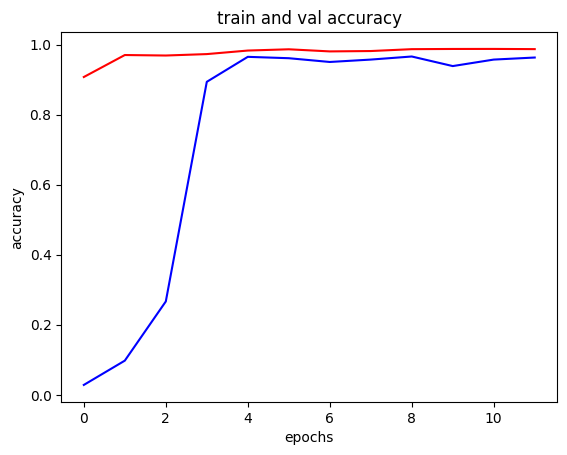

In [16]:
plt.plot(actualEpochs, acc, "r", label="train_acc")
plt.plot(actualEpochs, val_acc, "b", label="val_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("train and val accuracy")
plt.show()


In [17]:
modelo_f=load_model(r"train_model\modelo1.keras")
classes = list(test_set.class_indices.keys())

In [18]:
def calculate_and_plot_f1_score(test_data, classes, modelo_f):
    test_labels = test_data.labels
    
    # Predecir utilizando el modelo cargado
    predictions = modelo_f.predict(test_data)
    
    # Obtener el reporte de clasificación que incluye el F1-score, recall, precision y el support
    report_str = classification_report(test_labels, np.argmax(predictions, axis=1), target_names=classes)

    # Imprimir el reporte de clasificación en texto
    print("Reporte:")
    print(report_str)

    # Convertir el reporte de clasificación a un diccionario
    report_dict = classification_report(test_labels, np.argmax(predictions, axis=1), target_names=classes, output_dict=True)

    # Calcular el F1-score promedio
    f1_score = report_dict['macro avg']['f1-score']
    print(f"El F1-score es: {f1_score}")

calculate_and_plot_f1_score(test_set, classes, modelo_f)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step
Reporte:
                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        16
     Agent.FYI       0.94      1.00      0.97        16
     Allaple.A       1.00      1.00      1.00       296
     Allaple.L       1.00      0.99      1.00       160
 Alueron.gen!J       0.96      1.00      0.98        24
     Autorun.K       0.00      0.00      0.00        16
       C2LOP.P       0.73      1.00      0.84        16
   C2LOP.gen!g       0.89      1.00      0.94        24
Dialplatform.B       1.00      1.00      1.00        24
     Dontovo.A       1.00      1.00      1.00        16
      Fakerean       1.00      0.97      0.98        32
 Instantaccess       1.00      1.00      1.00        40
    Lolyda.AA1       1.00      1.00      1.00        24
    Lolyda.AA2       0.96      1.00      0.98        24
    Lolyda.AA3       1.00      1.00      1.00        16
     Lolyda.AT       1.00      0.94      0.97        

C:\Users\zapat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zapat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zapat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

NOTA: revisar las familias "Swizzor.gen!I" y "Autorun.K"

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step


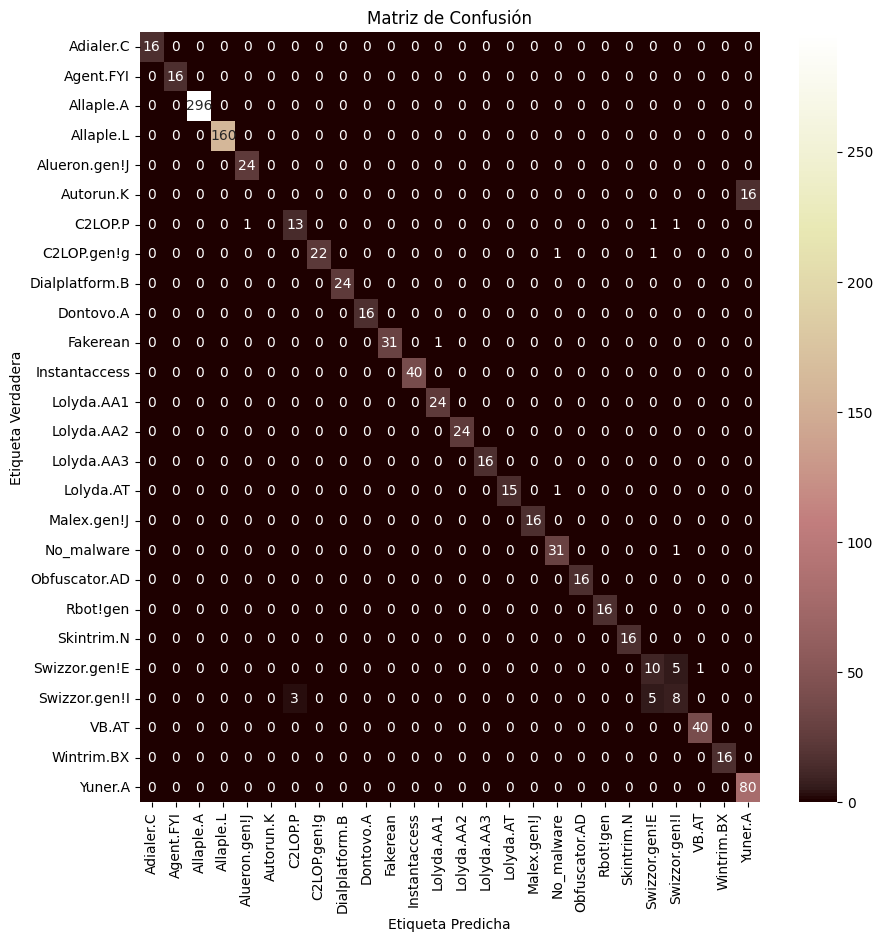

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Obtener las predicciones del modelo en el conjunto de prueba
predictions = model.predict(test_set)

# Convertir las predicciones de las probabilidades a clases
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
true_classes = test_set.classes

# Obtener la lista de nombres de las clases
class_names = list(test_set.class_indices.keys())

# Calcular la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)


# Crear un mapa de calor utilizando seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='pink', xticklabels=class_names, yticklabels=class_names, facecolor='#800080')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()
